<a href="https://colab.research.google.com/github/piyush-bhandari-commits/self-learn-repo/blob/master/Text_Classification_Hate_Speech_and_Offensive_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from imblearn.over_sampling import RandomOverSampler
random.seed(24)
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.patches as mpatches
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
import string
import re
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
results = dict()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Reading the raw data file
raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MSCI 641 Text Analytics/labeled_data.csv')
raw_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Removing unwanted columns from the dataset
dataset = raw_data.drop(raw_data.columns[:5], axis=1)
dataset.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


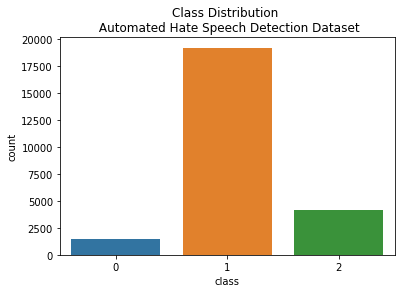

In [ ]:
# Understanding the class distribution of the dataset
plt.title('Class Distribution \n Automated Hate Speech Detection Dataset')
sns.countplot(data=dataset, x='class')

In [ ]:
# Performing random-sampling to balance the dataset
X = dataset['tweet'].values.reshape(-1,1)
y = dataset['class'].values.reshape(-1,1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = oversample.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Splitting the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.20, random_state=42)

train_data = pd.DataFrame(data=X_train, columns=['tweet'])
train_data['class'] = y_train

test_data = pd.DataFrame(data=X_test, columns=['tweet'])
test_data['class'] = y_test

print('Train data has {} rows and {} columns'.format(train_data.shape[0], train_data.shape[1]))
print('Test data has {} rows and {} columns'.format(test_data.shape[0], test_data.shape[1]))

Train data has 46056 rows and 2 columns
Test data has 11514 rows and 2 columns


In [ ]:
# Cleaning the training data to remove noise and unwanted words
def clean_text(text):
    no_user_tweet = re.sub('@[\w]*', '', text.lower())
    no_url_tweet = re.sub(r"http\S+", "", no_user_tweet)
    no_punct_text = re.sub("[^a-zA-Z#]", " ", no_url_tweet)
    no_small_text = " ".join([word for word in no_punct_text.split() if len(word)>2])
    no_stop_text = " ".join([word for word in no_small_text.split() if word not in stopwords])
    tokens = re.split('\W+', no_stop_text)
    return tokens

train_data['clean_tweet'] = train_data['tweet'].apply(lambda x: clean_text(x))
train_data['tweet_sentence'] = train_data['clean_tweet'].apply(lambda x: " ".join(x))
train_data.head(5)

,tweet,class,clean_tweet,tweet_sentence
0,"@Ken_GTH nahh , whatever you are spook or spic...",0,"[nahh, whatever, spook, spic, still, like, goo...",nahh whatever spook spic still like good day
1,When I'm a relationship I'm erasing twitter cu...,1,"[relationship, erasing, twitter, cuz, many, bi...",relationship erasing twitter cuz many bitches ...
2,Gansitos are ATG beaner candy,1,"[gansitos, atg, beaner, candy]",gansitos atg beaner candy
3,RT @hiteshrangra: Sonia never criticises @Arvi...,2,"[sonia, never, criticises, kejriwal, trashes, ...",sonia never criticises kejriwal trashes every ...
4,I love Liv when she gets ghetto,2,"[love, liv, gets, ghetto]",love liv gets ghetto


In [ ]:
# Coverting train and test set to sequences
max_words = 30000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['clean_tweet'])

word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(train_data['clean_tweet'])
x_train_pad = pad_sequences(x_train_seq, maxlen=200)
y_train_cat = to_categorical(train_data['class'])

x_test_seq = tokenizer.texts_to_sequences(test_data['tweet'])
x_test_pad = pad_sequences(x_test_seq, maxlen=200)
y_test_cat = to_categorical(test_data['class'])

# Training Models using Word2Vec

In [ ]:
# Training Word2Vec model on the given corpus of words
w2v_model = Word2Vec(train_data['clean_tweet'], size=200, workers=3, window=3, sg=0, seed=42)

## CNN Model

In [ ]:
cnn_w2v_model = Sequential()
cnn_w2v_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))

cnn_w2v_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_w2v_model.add(Dropout(0.3))
cnn_w2v_model.add(MaxPooling1D(pool_size=2))
cnn_w2v_model.add(Dropout(0.2))
cnn_w2v_model.add(Flatten())
cnn_w2v_model.add(Dense(250, activation='relu'))
cnn_w2v_model.add(Dropout(0.2))
cnn_w2v_model.add(Dense(3, activation='softmax'))
cnn_w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_w2v_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
288/288 [==============================] - 52s 182ms/step - loss: 0.4277 - accuracy: 0.8218 - val_loss: 0.1672 - val_accuracy: 0.9477
Epoch 2/3
288/288 [==============================] - 52s 179ms/step - loss: 0.1137 - accuracy: 0.9633 - val_loss: 0.1153 - val_accuracy: 0.9615
Epoch 3/3
288/288 [==============================] - 52s 180ms/step - loss: 0.0616 - accuracy: 0.9796 - val_loss: 0.1126 - val_accuracy: 0.9653


In [ ]:
y_predict = cnn_w2v_model.predict(x_test_pad)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['cnn_w2v'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      3849
           1       0.87      0.91      0.89      3794
           2       0.96      0.98      0.97      3871

    accuracy                           0.92     11514
   macro avg       0.93      0.92      0.92     11514
weighted avg       0.93      0.92      0.92     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

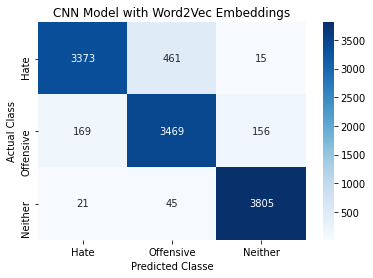

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('CNN Model with Word2Vec Embeddings') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

## LSTM Model

In [ ]:
lstm_w2v_model = Sequential()
lstm_w2v_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))
lstm_w2v_model.add(LSTM(units=50, return_sequences=False))
lstm_w2v_model.add(Dropout(0.2))
lstm_w2v_model.add(Dense(units = 3, activation='softmax'))
lstm_w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_w2v_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
288/288 [==============================] - 140s 487ms/step - loss: 0.4097 - accuracy: 0.8449 - val_loss: 0.1808 - val_accuracy: 0.9409
Epoch 2/3
288/288 [==============================] - 139s 484ms/step - loss: 0.1233 - accuracy: 0.9592 - val_loss: 0.1494 - val_accuracy: 0.9550
Epoch 3/3
288/288 [==============================] - 138s 481ms/step - loss: 0.0744 - accuracy: 0.9770 - val_loss: 0.1323 - val_accuracy: 0.9594


In [ ]:
y_predict = lstm_w2v_model.predict(x_test_pad)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['lstm_w2v'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3849
           1       0.89      0.91      0.90      3794
           2       0.97      0.95      0.96      3871

    accuracy                           0.93     11514
   macro avg       0.93      0.93      0.93     11514
weighted avg       0.93      0.93      0.93     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

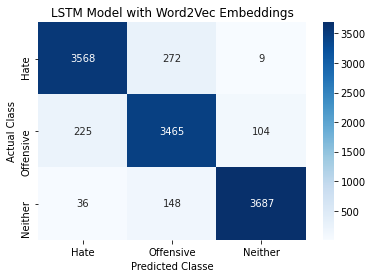

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('LSTM Model with Word2Vec Embeddings') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

## MLP Model

In [ ]:
mlp_w2v_model = Sequential()
mlp_w2v_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))
mlp_w2v_model.add(Dense(150, activation='relu'))
mlp_w2v_model.add(Dropout(0.2))
mlp_w2v_model.add(Flatten())
mlp_w2v_model.add(Dense(units = 3, activation='softmax'))
mlp_w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_w2v_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
288/288 [==============================] - 74s 258ms/step - loss: 0.4522 - accuracy: 0.8251 - val_loss: 0.1850 - val_accuracy: 0.9401
Epoch 2/3
288/288 [==============================] - 72s 250ms/step - loss: 0.1120 - accuracy: 0.9644 - val_loss: 0.1279 - val_accuracy: 0.9592
Epoch 3/3
288/288 [==============================] - 71s 247ms/step - loss: 0.0559 - accuracy: 0.9833 - val_loss: 0.1270 - val_accuracy: 0.9631


In [ ]:
y_predict = mlp_w2v_model.predict(x_test_pad)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['mlp_w2v'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3849
           1       0.87      0.90      0.89      3794
           2       0.96      0.97      0.96      3871

    accuracy                           0.92     11514
   macro avg       0.92      0.92      0.92     11514
weighted avg       0.92      0.92      0.92     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

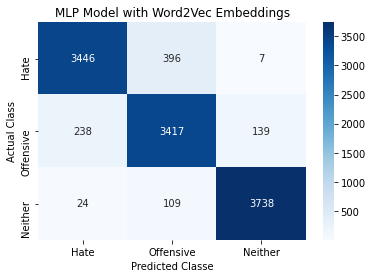

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('MLP Model with Word2Vec Embeddings') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

# Training Models using Pre-Trained GloVe Embeddings

In [ ]:
f = open('/content/drive/My Drive/Colab Notebooks/glove.twitter.27B.50d.txt')
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 1193514 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))

tokens = []
labels = []

for word,i in word_index.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        tokens.append(embedding_matrix[i])
        labels.append(word)

## CNN Model

In [ ]:
cnn_glove_model = Sequential()
cnn_glove_model.add(Embedding(len(word_index) + 1, 50,
                    input_length=x_train_pad.shape[1],
                    trainable=False, weights=[embedding_matrix]))
cnn_glove_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_glove_model.add(Dropout(0.3))
cnn_glove_model.add(MaxPooling1D(pool_size=2))
cnn_glove_model.add(Dropout(0.2))
cnn_glove_model.add(Flatten())
cnn_glove_model.add(Dense(250, activation='relu'))
cnn_glove_model.add(Dropout(0.2))
cnn_glove_model.add(Dense(3, activation='softmax'))
# model.add(Dropout(0.1))
cnn_glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_glove_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
288/288 [==============================] - 22s 77ms/step - loss: 0.7003 - accuracy: 0.6929 - val_loss: 0.5290 - val_accuracy: 0.8033
Epoch 2/3
288/288 [==============================] - 22s 77ms/step - loss: 0.5352 - accuracy: 0.7851 - val_loss: 0.4630 - val_accuracy: 0.8289
Epoch 3/3
288/288 [==============================] - 23s 79ms/step - loss: 0.4730 - accuracy: 0.8106 - val_loss: 0.3865 - val_accuracy: 0.8529


In [ ]:
y_predict = cnn_glove_model.predict(x_test_pad)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['cnn_glove'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      3849
           1       0.82      0.79      0.80      3794
           2       0.86      0.95      0.90      3871

    accuracy                           0.83     11514
   macro avg       0.83      0.83      0.83     11514
weighted avg       0.83      0.83      0.83     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

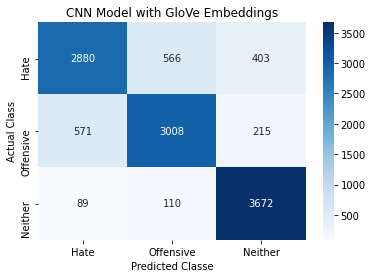

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('CNN Model with GloVe Embeddings') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

## LSTM Model

In [ ]:
lstm_glove_model = Sequential()
lstm_glove_model.add(Embedding(len(word_index) + 1, 50,
                    input_length=x_train_pad.shape[1],
                    trainable=False, weights=[embedding_matrix]))
lstm_glove_model.add(LSTM(units=50, return_sequences=False))
lstm_glove_model.add(Dropout(0.2))
lstm_glove_model.add(Dense(units = 3, activation='softmax'))
lstm_glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_glove_model.fit(x_train_pad, y_train_cat, batch_size= 128, epochs=3, validation_split=0.20)

Epoch 1/3
288/288 [==============================] - 58s 203ms/step - loss: 0.6555 - accuracy: 0.7254 - val_loss: 0.5123 - val_accuracy: 0.7941
Epoch 2/3
288/288 [==============================] - 58s 200ms/step - loss: 0.4770 - accuracy: 0.8127 - val_loss: 0.4370 - val_accuracy: 0.8313
Epoch 3/3
288/288 [==============================] - 58s 201ms/step - loss: 0.4183 - accuracy: 0.8351 - val_loss: 0.3887 - val_accuracy: 0.8497


In [ ]:
y_predict = lstm_glove_model.predict(x_test_pad)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['lstm_glove'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      3849
           1       0.83      0.81      0.82      3794
           2       0.87      0.95      0.91      3871

    accuracy                           0.84     11514
   macro avg       0.84      0.84      0.84     11514
weighted avg       0.84      0.84      0.84     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

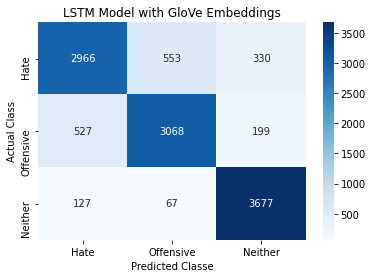

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('LSTM Model with GloVe Embeddings') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

## MLP Model

In [ ]:
mlp_glove_model = Sequential()
mlp_glove_model.add(Embedding(len(word_index) + 1, 50,
                    input_length=x_train_pad.shape[1],
                    trainable=False, weights=[embedding_matrix]))
mlp_glove_model.add(Dense(150, activation='relu'))
mlp_glove_model.add(Dropout(0.2))
mlp_glove_model.add(Flatten())
mlp_glove_model.add(Dense(units = 3, activation='softmax'))
mlp_glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_glove_model.fit(x_train_pad, y_train_cat, batch_size= 128, epochs=3, validation_split=0.20)

Epoch 1/3
288/288 [==============================] - 33s 116ms/step - loss: 0.6371 - accuracy: 0.7345 - val_loss: 0.5059 - val_accuracy: 0.8025
Epoch 2/3
288/288 [==============================] - 33s 116ms/step - loss: 0.4695 - accuracy: 0.8187 - val_loss: 0.4340 - val_accuracy: 0.8363
Epoch 3/3
288/288 [==============================] - 34s 117ms/step - loss: 0.4139 - accuracy: 0.8453 - val_loss: 0.3841 - val_accuracy: 0.8608


In [ ]:
y_predict = mlp_glove_model.predict(x_test_pad)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['mlp_glove'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      3849
           1       0.77      0.81      0.79      3794
           2       0.87      0.92      0.90      3871

    accuracy                           0.81     11514
   macro avg       0.81      0.81      0.81     11514
weighted avg       0.81      0.81      0.81     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

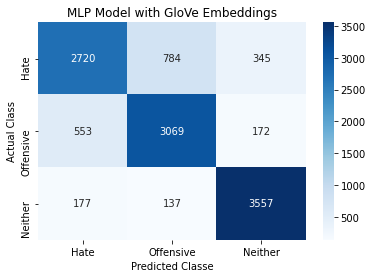

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('MLP Model with GloVe Embeddings') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

# Training Models with N-grams

In [ ]:
# Using TF-IDF Vectorizer to transform training data into vectors of equal length
tfidf_vect = TfidfVectorizer(min_df=5, max_features=500)
X_train_tfidf = tfidf_vect.fit_transform(train_data['tweet_sentence'])
X_test_tfidf = tfidf_vect.transform(test_data['tweet'])
y_train_tfidf = train_data['class']
y_test_tfidf = test_data['class']

In [ ]:
# Reshaping vectors to 3 dimensional format for model input
X_train_3d = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_3d = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

## CNN Model

In [ ]:
cnn_tfidf_model = Sequential()
cnn_tfidf_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(500, 1)))
cnn_tfidf_model.add(Dropout(0.3))
cnn_tfidf_model.add(MaxPooling1D(pool_size=2))
cnn_tfidf_model.add(Dropout(0.2))
cnn_tfidf_model.add(Flatten())
cnn_tfidf_model.add(Dense(250, activation='relu'))
cnn_tfidf_model.add(Dropout(0.2))
cnn_tfidf_model.add(Dense(3, activation='softmax'))
cnn_tfidf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_tfidf_model.fit(X_train_3d, y_train_cat, batch_size=300, epochs=3, validation_split=0.20)

Epoch 1/3
123/123 [==============================] - 34s 278ms/step - loss: 0.6163 - accuracy: 0.7677 - val_loss: 0.4823 - val_accuracy: 0.8129
Epoch 2/3
123/123 [==============================] - 31s 254ms/step - loss: 0.4637 - accuracy: 0.8214 - val_loss: 0.4252 - val_accuracy: 0.8372
Epoch 3/3
123/123 [==============================] - 31s 253ms/step - loss: 0.4215 - accuracy: 0.8393 - val_loss: 0.3815 - val_accuracy: 0.8571


In [ ]:
y_predict = cnn_tfidf_model.predict(X_test_3d)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['cnn_tfidf'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      3849
           1       0.86      0.81      0.83      3794
           2       0.88      0.95      0.91      3871

    accuracy                           0.85     11514
   macro avg       0.85      0.85      0.85     11514
weighted avg       0.85      0.85      0.85     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

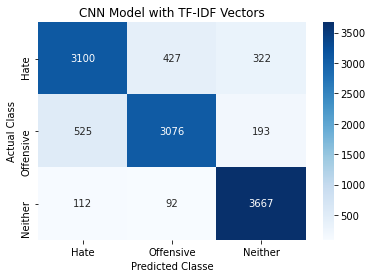

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('CNN Model with TF-IDF Vectors') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

## LSTM Model

In [ ]:
lstm_tfidf_model = Sequential()
lstm_tfidf_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
lstm_tfidf_model.add(LSTM(units=30))
lstm_tfidf_model.add(Dense(units = 3, activation='softmax'))
lstm_tfidf_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_tfidf_model.fit(X_train_3d, y_train_cat, epochs=3, batch_size=300, validation_split=0.20)

Epoch 1/3
123/123 [==============================] - 195s 2s/step - loss: 1.0867 - acc: 0.3757 - val_loss: 1.0730 - val_acc: 0.4006
Epoch 2/3
123/123 [==============================] - 194s 2s/step - loss: 1.0686 - acc: 0.4123 - val_loss: 1.0555 - val_acc: 0.4464
Epoch 3/3
123/123 [==============================] - 196s 2s/step - loss: 1.0537 - acc: 0.4391 - val_loss: 1.0517 - val_acc: 0.4383


In [ ]:
y_predict = lstm_tfidf_model.predict(X_test_3d)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['lstm_tfidf'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.44      0.54      0.49      3849
           1       0.39      0.33      0.35      3794
           2       0.50      0.46      0.48      3871

    accuracy                           0.45     11514
   macro avg       0.44      0.45      0.44     11514
weighted avg       0.44      0.45      0.44     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

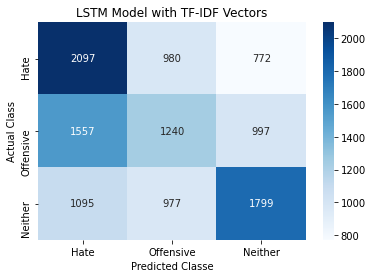

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('LSTM Model with TF-IDF Vectors') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

## MLP Model

In [ ]:
mlp_tfidf_model = Sequential()
mlp_tfidf_model.add(Dense(150, activation='relu', input_shape=(500, 1)))
mlp_tfidf_model.add(Dropout(0.2))
mlp_tfidf_model.add(Flatten())
mlp_tfidf_model.add(Dense(units = 3, activation='softmax'))
mlp_tfidf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_tfidf_model.fit(X_train_3d, y_train_cat, batch_size=300, epochs=3, validation_split=0.20)

Epoch 1/3
123/123 [==============================] - 62s 506ms/step - loss: 0.8009 - accuracy: 0.7554 - val_loss: 0.5718 - val_accuracy: 0.8069
Epoch 2/3
123/123 [==============================] - 62s 507ms/step - loss: 0.5176 - accuracy: 0.8148 - val_loss: 0.4899 - val_accuracy: 0.8216
Epoch 3/3
123/123 [==============================] - 62s 504ms/step - loss: 0.4728 - accuracy: 0.8274 - val_loss: 0.4661 - val_accuracy: 0.8290


In [ ]:
y_predict = mlp_tfidf_model.predict(X_test_3d)
y_predict_final = np.argmax(y_predict, axis=1)
precision, recall, f1, support = precision_recall_fscore_support(test_data['class'].values, y_predict_final, average='weighted')
results['mlp_tfidf'] = [precision, recall, f1]
print(classification_report(test_data['class'].values, y_predict_final))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      3849
           1       0.79      0.82      0.81      3794
           2       0.86      0.92      0.89      3871

    accuracy                           0.83     11514
   macro avg       0.82      0.82      0.82     11514
weighted avg       0.82      0.83      0.82     11514



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

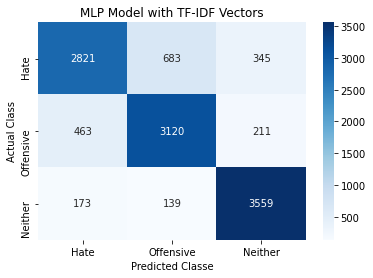

In [ ]:
cm = confusion_matrix(test_data['class'].values, y_predict_final, labels= [0, 1, 2])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('MLP Model with TF-IDF Vectors') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

# Visualizations

In [ ]:
df_result = pd.DataFrame(results)
df_result.index = ['precision', 'recall', 'f1-score']
df_result

,cnn_w2v,lstm_w2v,mlp_w2v,cnn_glove,lstm_glove,mlp_glove,cnn_tfidf,lstm_tfidf,mlp_tfidf
precision,0.941123,0.931593,0.921314,0.828779,0.841927,0.810542,0.854045,0.444930,0.824363
recall,0.940334,0.931040,0.920705,0.830294,0.843408,0.811707,0.854872,0.446066,0.825083
f1-score,0.940573,0.931245,0.920822,0.828223,0.841836,0.810016,0.853743,0.442562,0.823600


In [ ]:
import pickle
pickle.dump(df_result, open( "/content/drive/My Drive/Colab Notebooks/results_dataframe.p", "wb" ) )

In [ ]:
import pickle
result_df = pickle.load(open( "/content/drive/My Drive/Colab Notebooks/results_dataframe.p", "rb" ) )
result_df

,cnn_w2v,lstm_w2v,mlp_w2v,cnn_glove,lstm_glove,mlp_glove,cnn_tfidf,lstm_tfidf,mlp_tfidf
precision,0.941123,0.931593,0.921314,0.828779,0.841927,0.810542,0.854045,0.444930,0.824363
recall,0.940334,0.931040,0.920705,0.830294,0.843408,0.811707,0.854872,0.446066,0.825083
f1-score,0.940573,0.931245,0.920822,0.828223,0.841836,0.810016,0.853743,0.442562,0.823600


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def get_plot(result_df, plot_title):
    labels = result_df.columns
    precision = [round(item, 2) for item in result_df.iloc[0].values]
    recall = [round(item, 2) for item in result_df.iloc[1].values]
    f1score = [round(item, 2) for item in result_df.iloc[2].values]

    x = np.arange(len(labels))  # the label locations
    width = 0.28  # the width of the bars


    fig, ax = plt.subplots(figsize=(6,5))
    # plt.figure(figsize=(10,10))
    rects1 = ax.bar(x + width, precision, width, label='Precision')
    rects2 = ax.bar(x + width*2, recall, width, label='Recall')
    rects3 = ax.bar(x + width*3, f1score, width, label='F1-score')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric Value (Weighted Average)')
    ax.set_xlabel('Model Name with Embedding')
    ax.set_title('{}'.format(plot_title))
    ax.set_xticks(x + width*2)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    
    fig.tight_layout()
    plt.savefig(plot_title)
    plt.show()

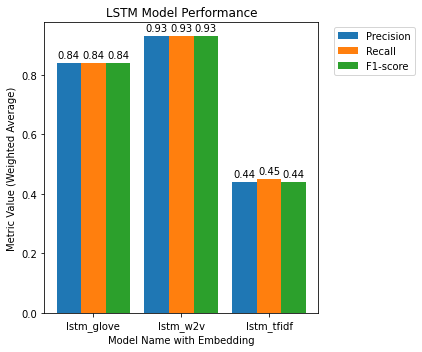

In [ ]:
lstm_result = result_df[['lstm_glove', 'lstm_w2v', 'lstm_tfidf']]
get_plot(lstm_result, 'LSTM Model Performance')

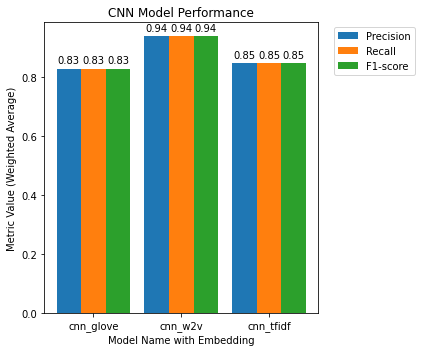

In [ ]:
cnn_result = result_df[['cnn_glove', 'cnn_w2v', 'cnn_tfidf']]
get_plot(cnn_result, 'CNN Model Performance')

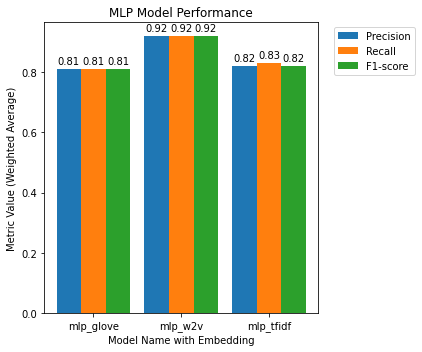

In [ ]:
mlp_result = result_df[['mlp_glove', 'mlp_w2v', 'mlp_tfidf']]
get_plot(mlp_result, 'MLP Model Performance')

# Qualitative Analysis

In [ ]:
# 0 - hate speech 1 - offensive language 2 - neither
print(test_data['tweet'][59])
print('\n Actual Class of Tweet {}'.format(test_data['class'][59]))
print('\n Predicted Class of Tweet {}'.format(y_predict_final[59]))

I missing something of my ofay friends. Day all scared by da recent happenings. Don't chu worry...ol Lamar say you like da colored folk

 Actual Class of Tweet 0

 Predicted Class of Tweet 0


In [ ]:
print(test_data['tweet'][27])
print('\n Actual Class of Tweet {}:'.format(test_data['class'][27]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[27]))

@kelvinkayyy safe bruv welcum to twitter my niggur

 Actual Class of Tweet 1:

 Predicted Class of Tweet 2:


In [ ]:
print(test_data['tweet'][7839])
print('\n Actual Class of Tweet {}:'.format(test_data['class'][7839]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[7839]))

Smh hate that hoe

 Actual Class of Tweet 0:

 Predicted Class of Tweet 1:


In [ ]:
index = 6341
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['class'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

Delete now you bitch ass nigga RT @Quanny_Quan: If the Redskins beat us I will delete my fucking IG

 Actual Class of Tweet 0:

 Predicted Class of Tweet 1:


In [ ]:
index = 6174
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['class'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

I ride around with #notint, so all them bitches can see me &#128526;&#128522;&#128129; #JetLife &#9992;&#65039;

 Actual Class of Tweet 1:

 Predicted Class of Tweet 0:


In [ ]:
index = 5992
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['class'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

@DolanGang you wouldn't know fag

 Actual Class of Tweet 0:

 Predicted Class of Tweet 1:


In [ ]:
index = 9
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['class'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

Pretending that he can make it rain, our ghetto president is in it for himself while govt money whores beg utilties to stay on one more day.

 Actual Class of Tweet 1:

 Predicted Class of Tweet 2:


In [ ]:
mismatch = []
for i in range(len(y_predict_final)):
    if y_predict_final[i]!=test_data['class'][i]:
        mismatch.append(i)